Импорт необходимых библиотек

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import cv2

import random

2022-05-10 00:49:40.744275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 00:49:40.744293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir = os.path.join('C:\Mushrooms')

batch_size = 100
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print('\n')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6711 files belonging to 9 classes.
Using 5369 files for training.


Found 6711 files belonging to 9 classes.
Using 1342 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


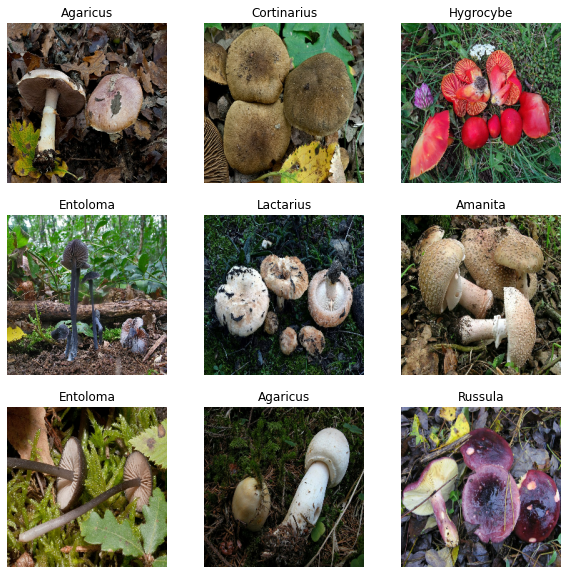

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 224, 224, 3)
(100,)


In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [7]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Создаём модель

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_classes = len(class_names)
print(len(class_names))

resnet_model = ResNet50(weights="imagenet")
resnet_model.summary()

last_layer = resnet_model.get_layer("avg_pool")
resnet_layers = Model(inputs=resnet_model.inputs, outputs=last_layer.output)

model = Sequential()
model.add(resnet_layers)
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable=False

model.compile(loss = 'sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

9
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

Удаляем плохие картинки

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

from struct import unpack
import os.path as osp
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for i in range(9):
    root_img = osp.join(data_dir,class_names[i])
    images = os.listdir(root_img)
    for img in images:
      image = osp.join(root_img,img)
      image = JPEG(image) 
      try:
        image.decode()   
      except:
        bads.append(img)


    for name in bads:
      os.remove(osp.join(root_img,name))

0.0 1.0


In [11]:
history = model.fit(train_ds, validation_data=val_ds,
                        epochs=10, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/10
54/54 [==============================] - 1410s 26s/step - loss: 2.0683 - accuracy: 0.3364 - val_loss: 1.1549 - val_accuracy: 0.6088
Epoch 2/10
54/54 [==============================] - 1351s 25s/step - loss: 1.0283 - accuracy: 0.6523 - val_loss: 0.9860 - val_accuracy: 0.6617
Epoch 3/10
54/54 [==============================] - 1350s 25s/step - loss: 0.8593 - accuracy: 0.7144 - val_loss: 0.8857 - val_accuracy: 0.6990
Epoch 4/10
54/54 [==============================] - 1354s 25s/step - loss: 0.7531 - accuracy: 0.7530 - val_loss: 0.8203 - val_accuracy: 0.7198
Epoch 5/10
54/54 [==============================] - 1372s 25s/step - loss: 0.6939 - accuracy: 0.7694 - val_loss: 0.8101 - val_accuracy: 0.7154
Epoch 6/10
54/54 [==============================] - 1353s 25s/step - loss: 0.6250 - accuracy: 0.7944 - val_loss: 0.7959 - val_accuracy: 0.7295
Epoch 7/10
54/54 [==============================] - 1356s 25s/step - loss: 0.5879 - accuracy: 0.8122 - val_loss: 0.7593 - val_accuracy: 0.7332

In [5]:
#model.save("mushrooms.h5")
lol_model = tf.keras.models.load_model("mushrooms.h5")

2022-05-10 00:50:58.193161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 00:50:58.193392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jaba/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-10 00:50:58.193444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jaba/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-10 00:50:58.193486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublas

In [2]:
def prepare(filepath):
    IMG_SIZE = 224
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape([1,IMG_SIZE,IMG_SIZE,3])

In [7]:
from numpy import argmax
classes = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']

prediction = lol_model.predict([prepare('test.jpg')])
print(prediction[0])

[0.00150441 0.16649523 0.00710366 0.01181037 0.00862838 0.3670977
 0.40659198 0.02623687 0.0045314 ]
